In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.cluster import k_means, kmeans_plusplus, KMeans
from sklearn.decomposition import PCA

# K-Means and Clustering

Clustering algorithms are a part of machine learning that attempts to group, based on the features in the dataset, records into "clusters" of similar examples. Clustering is unsupervised - we don't know which groupings we'll end up with in advance (in contrast to something like logistic regression, where we know going in what the resulting classes are, we are just trying to fit each records into one of those groups)

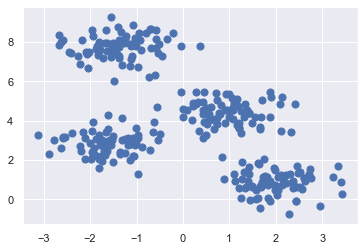

In [3]:
from sklearn.datasets._samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)

### Visually Clustering

We can look at the dummy data and it is pretty clearly broken up into 4 blobs. Clustering works by finding these blobs of similar points, and grouping them into "like" groups. 

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
clusters = kmeans.predict(X)

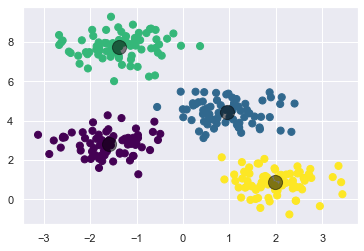

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=clusters, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)


## K-Means Clustering and Inertia

Much like logistic regression and gradient descent, clustering relies on an iteritive algorithm to find the corect clustering. In this case the algorithm attempts to minimise a metric called inertia. Inertia is the within-cluster sum-of-squares, roughly the compactness of each cluster. 

$ \sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)  $

This calculation is just the sum of squares distance of each point to the center of that group. 

While using this metric of inertia generates "tight" groupings, there are a few concerns:
<ul>
<li> The distance from the center point is radial. If there is an irregular pattern to the data distribution, this may not make sense. 
<li> When using high dimension data, the distances can inflate. Using an algorithm to reduce dimensionality like PCA can help this. 
</ul>

The cluster centers are randomly placed, then the inertia is calculated and the points are updated. This process uses something called Expectation Maximization, but the effect is exactly as though we were doing gradient descent with a cost function - eventually we converge on the solution. One issue is that, like with some gradient descent problems, we can have the optimized solution fall into a local minima, not the global solution. To combat this the kMeans built into sklearn defaults to using 10 iterations, in each one the starting point of the centroids is different, so we can likely avoid this. We can also call a paramater called "init" which changes the starting placement of the centroids from random to "k-means++" which looks at the data to generate smart starting points to speed convergance on a solution, and avoid local minima. 

### Clustering Example

Using real data, we'll cluster the diabetes havers/not havers based on their metrics. 

In [6]:
#Load Data
df = pd.read_csv("data/diabetes.csv")
df.drop(columns={"Outcome"}, inplace=True)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


### Scale and PCA Data

Here we'll scale the data and also run it through PCA so we can project it into 2D for visualization. Our data is currently in 8 dimensions - we can't really draw that effectively. 

In [7]:
from sklearn.preprocessing import MinMaxScaler
X_clus = MinMaxScaler().fit_transform(df)
X_c = PCA(2).fit_transform(X_clus)

### Plot Clusters

We need to specify the number of clusters to produce. We can plot several selections of k and see visually how well that fits our data. 

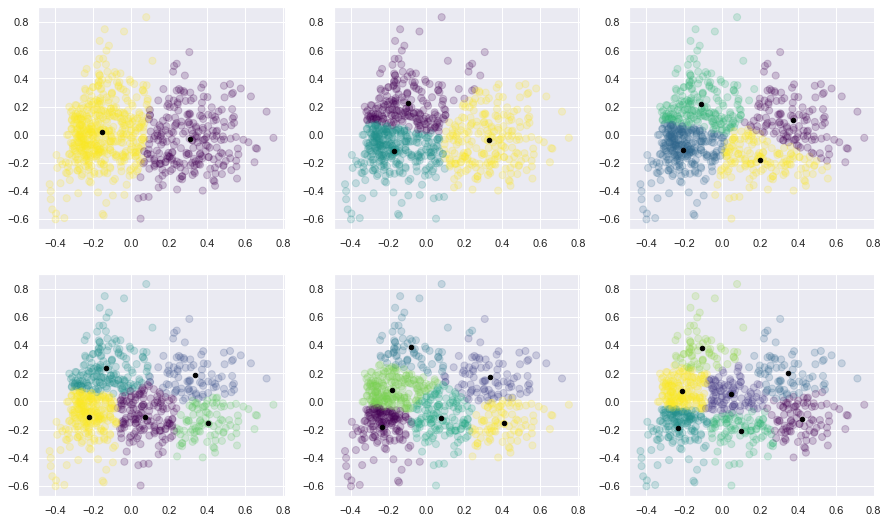

In [8]:
nc = [2,3,4,5,6,7]
fig, ax = plt.subplots(2, 3, figsize=(15, 9))
row = 0
col = 0
for n in nc:
    kmeans = KMeans(n_clusters=n, max_iter=1000)
    kmeans.fit(X_c)
    y_kmeans = kmeans.predict(X_c)
    ax[row][col].scatter(X_c[:,0], X_c[:,1], c=y_kmeans, s=50, cmap='viridis', alpha=.2)
    centers = kmeans.cluster_centers_
    #print(centers)
    ax[row][col].scatter(centers[:, 0], centers[:, 1], c='black', s=20)
    col += 1
    if col >= 3:
        col = 0
        row += 1
plt.show()


## How Many Clusters?

How many clusters should we have? If our data is easy to visualize, we can just look at it. If it isn't, we need some analysis. Two ways are:
<ul>
<li> Elbow method - like with PCA, we can plot the inertia and choose where it flattens. Just like the scree plot. 
<li> Silhouette - measure of how similar points are within a cluster compared to the distance from other clusters. Basically a measure of separation between clusters, analagous to the division boundaries we looked at with SVMs. We want high silhouette scores. 
</ul>

These methods can be used in cocert with each other to determine optimal number of clusters. 

C:\Users\allyr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


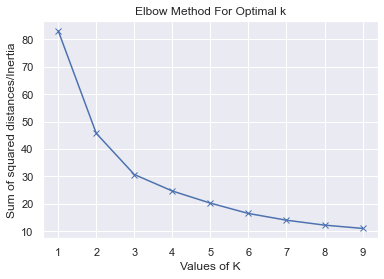

In [9]:
# Elbow Method
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_c)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

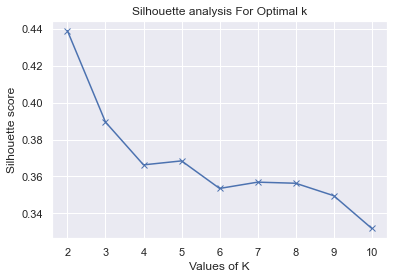

In [10]:
#Silhouette Score
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_c)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(X_c, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

#### Load Digit Data

We can try to cluster the digits that we looked at previously. We can try to group the drawings into digits without using their labels. 

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
Xp = digits.data
yp = digits.target

For this we know that we'll need 10 clusters, so that part is easy. 

In [12]:
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(Xp)
kmeans.cluster_centers_.shape


(10, 64)

#### Plot the "Average" Digit

We can plot the center of each cluster. These centers are each 64 dimension points - one for each feature. The center is the middle of each cluster, so it isn't the "average" one of the images that we started with, it is the average of all the pixels of each drawing of that number. Or more accurately the average of all the pixels of each digit that got clustered together - correctly or incorrectly. 

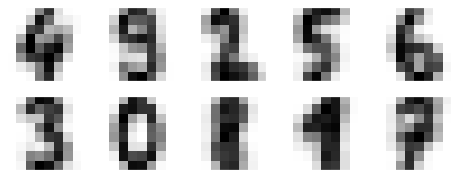

In [14]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

### Digits are Grouped!

We don't know the classes going in, but our clustering has managed to group the digits pretty well! 

#### But What ARE the Predictions?

Clustering doesn't know anything about the labels of our digits, all it is doing is grouping together the similar pieces of data. To figure out which are correct or incorrect we need to label each group. To do so, we'll take the mode, or most frequent, from the set of labels. We can then check an entire group against the correct label.

We generally don't know labels when clustering, but since this is a trial run, we do. We can pull those in to check our accuracy. 

In [15]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(yp[mask])[0]

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(yp, labels)

0.7941012799109627

Text(89.18, 0.5, 'predicted label')

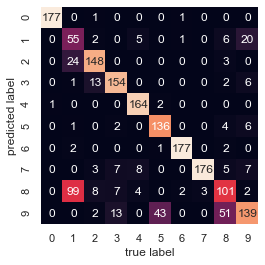

In [17]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

### Results

We didn't do too badly! Most errors are what we'd expect, especially with such low resolution digits. Things that are similar, like skinny 8s and 1s, or 8s and 9s are often confused, other than those we are quite accurate. 

But can we do better...

## t-SNE 

t-SNE is t-Distributed Stochastic Neighbor Embedding - a dimension reduction technique that is non-linear, probabilistic, and typically used to project high dimension data to a 2D plot. tSNE is new - invented in 2008. 

tSNE does the same thing as PCA, it takes a dataset that has a high number of dimensions and translates it to a lower number of dimensions. The math behind the scenes is different, and pretty complex. tSNE is a type of manifold learning - or non-linear dimension reduction - in contrast to PCA and LSA which are both linear techniques. This gives tSNE an advantage that it is often able to better project high dimension data in a way that makes good visualizations - which is the primary use. We'll look at tSNE a little more when we do larger data with neural networks. Here, we can use tSNE as a dimension reduction tool just as we would PCA. 

#### How tSNE Works

tSNE very roughly measures the distance between points in space - N dimensional space where N is the dimensionality of the data. These distances are then used with a t-distribution (hence the t) to generate probabilities of the relative similarities between points. These are then mapped down to 2 (usually) dimensions randomly, based on the probability. This is a very loose generalization, details are here: https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a but it goes well beyond what we need to care about. We can treat tSNE as a more flexible PCA here and cut our dimensions from 64 to 2. 

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9426822481914302

#### Plot tSNE Projections

We can plot the tSNE projections for the clusters. Since the data is in 2D, we can visualize it.  

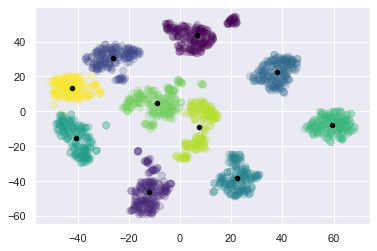

In [ ]:
plt.scatter(digits_proj[:,0], digits_proj[:,1], c=clusters, s=50, cmap='viridis', alpha=.2)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=20)

### tSNE and Plotting High Dimension Data and Perplexity

As an example, we can plot something in lots of dimensions into fewer - the breast cancer dataset. This dataset has 30 dimensions, so doing a scatter plot of the data the "normal" way would require just selecting 2 dimensions to use. Here we can project those 30 dimensions down to 2, so we can visualize our data. 

In [ ]:
from sklearn.datasets import load_breast_cancer
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

df = sklearn_to_df(load_breast_cancer())
y1 = df["target"]
X1 = df.drop(columns="target")
red = y1 == 0
green = y1 == 1
X1 = MinMaxScaler().fit_transform(X1)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Projection with PCA

First, we can use PCA to reduce this to 2 dimensions and see what we get. We'll color the data according to it's true label, so we can visually see the separation when plotted. 

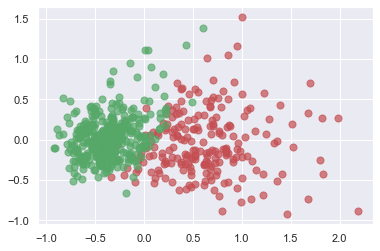

In [ ]:
#PCA
b_PCA = PCA(2).fit_transform(X1)
plt.scatter(b_PCA[red,0], b_PCA[red,1],s=50, c='r', alpha=.7)
plt.scatter(b_PCA[green,0], b_PCA[green,1], s=50, c='g', alpha=.7)

### Now tSNE

The tSNE projections will vary, you may get one that is quite different. 

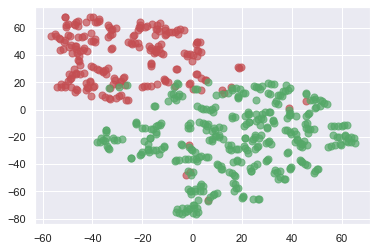

In [ ]:
# tSNE
#b_tSNE = TSNE(n_components=2, init='random', perplexity = 30).fit_transform(X1)
b_tSNE = TSNE(n_components=2, perplexity = 5).fit_transform(X1)
plt.scatter(b_tSNE[red,0], b_tSNE[red,1],s=50, c='r', alpha=.7)
plt.scatter(b_tSNE[green,0], b_tSNE[green,1], s=50, c='g', alpha=.7)

### Perplexity

Perplexity is an argument for tSNE, it can radically change the projection that we get. Perplexity roughly controls how local vs global the algorithm looks when trying to find structure in the data. Higher perplexities cause the algorithm to look more globally at the data - so it will look for relationships between points that are "farther apart" (in N-dimensional space). Lower perplexities cause the algorithm to look more locally. Typical values are around 5 to 50, when visualizing, we kind of need to guess and check. 

There is a very good explainer of tSNE along with many good visualizations here: https://distill.pub/2016/misread-tsne/ 

As the perplexity changes we can sometimes get shapes and patterns in the data. 

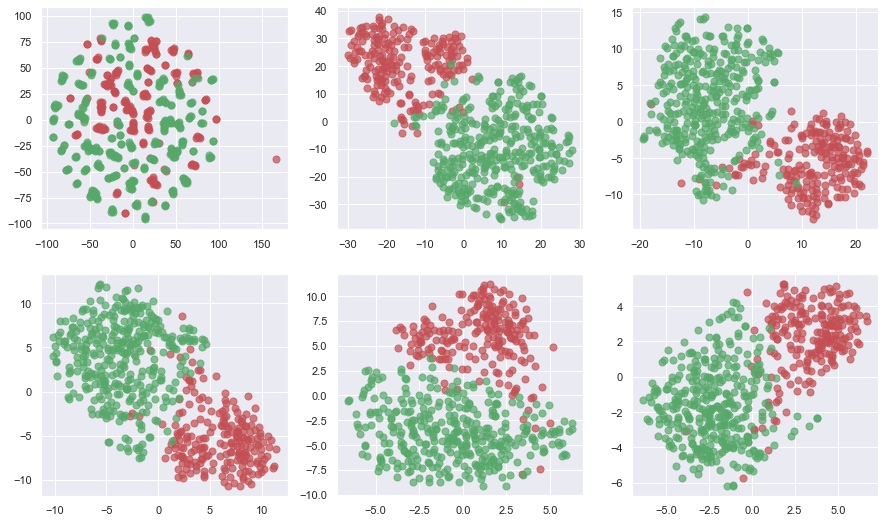

In [ ]:
#Plot several perplexities
fig, ax = plt.subplots(2, 3, figsize=(15, 9))
row = 0
col = 0
perp = [1,25,50,75,100,150]
for p in perp:
    b_tSNE = TSNE(n_components=2, init='random', perplexity = p).fit_transform(X1)
    ax[row][col].scatter(b_tSNE[red,0], b_tSNE[red,1],s=50, c='r', alpha=.7)
    ax[row][col].scatter(b_tSNE[green,0], b_tSNE[green,1], s=50, c='g', alpha=.7)
    col += 1
    if col >= 3:
        col = 0
        row += 1
plt.show()

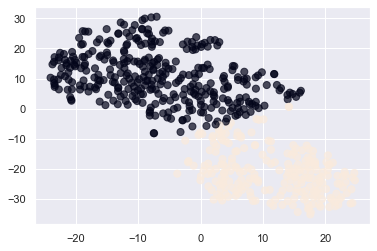

In [ ]:
#### Cluster the Breast Cancer Data
b_tSNE = TSNE(n_components=2, init='random', perplexity = 30).fit_transform(X1)
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(b_tSNE)
plt.scatter(b_tSNE[:,0], b_tSNE[:,1],s=50, c=clusters, alpha=.7)

### tSNE Conclusion

tSNE is basically a functional equivalent to PCA that does not depend on linear relationships. 

We can use it to reduce dimensions just like PCA. Generally, we'd want to try it after PCA, or if PCA seems to not do a great job with our data. It is way slower

The primary use of tSNE is to visualize high dimension data in 2D, the structure in the data that it is able to capture tends to make it better suited to creating useful projections. tSNE has a few considerations:
<ul>
<li> tSNE can be very slow, while PCA is very fast. This can be a big limitation on large datasets if PCA is used to reduce dimensions for modelling. 
<li> When using tSNE with massive numbers of features, it may be practical to use PCA first, to reduce the dimensions down to 50ish. 
<li> Sriously, it is slow with lots of data. 
</ul>

In the manifold learning package of sklearn there are other dimension reduction algorithms that do the same thing. Each of these may have different strengths and weaknesses when dealing with different types of data. If we are reducing dimensions we probably want to start with PCA for dimension reduction, tSNE for visualization, and move on to something else if needed. 

## Working Example

Cluster the wine. Customer_Segment is the target, so we'll drop that for clustering. 

Project a plot with tSNE, I used a perplexity of 8 and got good results. Try a few. 

In [ ]:
wine = pd.read_csv("data/Wine.csv")
wine.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


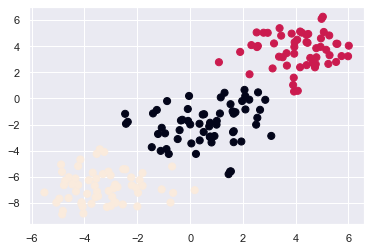

In [ ]:
#Cluster and Plot
X_wine = MinMaxScaler().fit_transform(wine.drop(columns={"Customer_Segment"}))
wine_t = TSNE(n_components=2, init='random', perplexity = 50).fit_transform(X_wine)
wine_k = KMeans(n_clusters=3)
clusters = wine_k.fit_predict(wine_t)
plt.scatter(wine_t[:,0], wine_t[:,1],s=50, c=clusters)

### Plot with Different Number of Clusters

We can cluster our data with a few different numbers of clusters to see what we get. 

C:\Users\allyr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


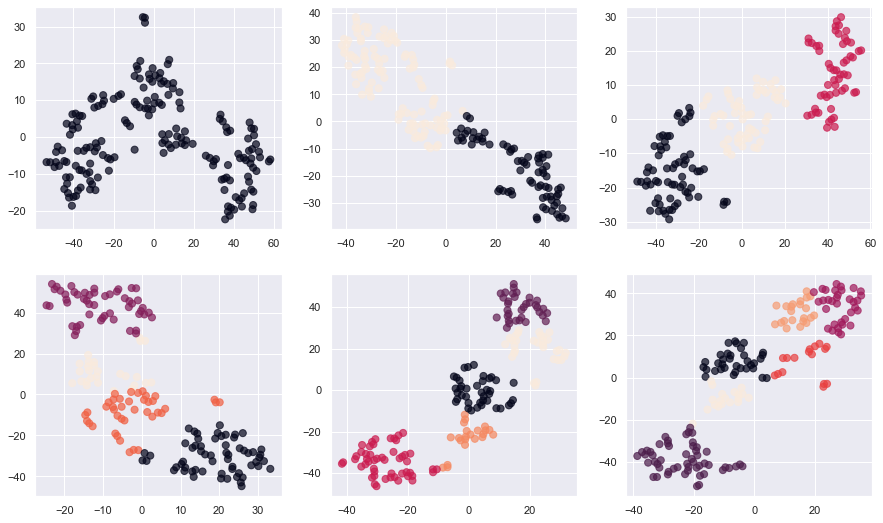

In [ ]:
#Plot
fig, ax = plt.subplots(2, 3, figsize=(15, 9))
row = 0
col = 0
clust = [1,2,3,4,5,6]
for c in clust:
    wine_t = TSNE(n_components=2, init='random', perplexity = 8).fit_transform(X_wine)
    wine_k = KMeans(n_clusters=c)
    clusters = wine_k.fit_predict(wine_t)
    ax[row][col].scatter(wine_t[:,0], wine_t[:,1],s=50, c=clusters, alpha=.7)
    col += 1
    if col >= 3:
        col = 0
        row += 1
plt.show()

#### Check the "Correct" Number of Clusters

I will use a silhouette to see what the best number of clusters is. Then check the actual labels from the data to compare. 

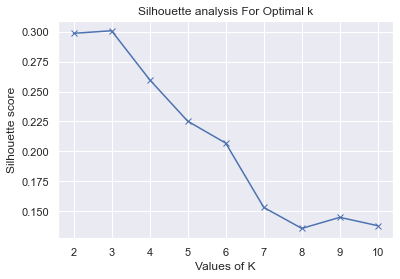

In [ ]:
#Silhouette Scores
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_wine)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(X_wine, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

In [ ]:
wine["Customer_Segment"].value_counts()

2    71
1    59
3    48
Name: Customer_Segment, dtype: int64